In [7]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.matcher import FlannMatcher

from autocnet.matcher import subpixel as sp 
from scipy.misc import imresize
import math

from IPython.display import display
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Basic Structures

In [8]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

# Perform the symmetry check
cg.symmetry_checks()
# Perform the ratio check
cg.ratio_checks(clean_keys = ['symmetry'])
# Create fundamental matrix
cg.compute_fundamental_matrices(clean_keys = ['symmetry', 'ratio'])


# Step: Compute the homographies and apply RANSAC
cg.compute_homographies(clean_keys=['symmetry', 'ratio'])

# Step: Compute the overlap ratio and coverage ratio
for s, d, edge in cg.edges_iter(data=True):
    edge.coverage_ratio(clean_keys=['symmetry', 'ratio'])

# Step: Compute subpixel offsets for candidate points
cg.subpixel_register(clean_keys=['ransac'])

cg.suppress(clean_keys=['symmetry', 'ratio', 'subpixel'])

# Define Stuff

In [9]:
def cifi(arr, scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], radii=list(range(1,12))):
    
    result = np.empty((len(scales), len(radii)))
    
    for i, s in enumerate(scales):
        new_arr = imresize(arr, s)
        for j, r in enumerate(radii):
            # Generate a circular mask
            a, b = (int(new_arr.shape[0] / 2),
                    int(new_arr.shape[1] / 2))
            
            if r > b or r > a:
                s =-1
                
            mask = circ_mask(new_arr.shape, (a,b), r, (0,360))
            
            inv_area = 1 / (2 * math.pi * r)
            s = np.sum(new_arr[mask]) * inv_area
            
            if s == 0:
                s = -1
            result[i,j] = s
    return result
    
def cifi2(arr, radii=list(range(1,12))):
    result = np.empty((arr.shape[0], arr.shape[1], len(radii)))
    
    for i, y in enumerate(range(arr.shape[0])):
        for j, x in enumerate(range(arr.shape[1])):
            for k, r in enumerate(radii):
                inv_area = 1 / (2 * math.pi * r)
                
                # Generate a circular mask
                mask = circ_mask(arr.shape, (i,j), r, (0,360))
                
                s = np.sum(arr[mask]) * inv_area
                
                if s == 0:
                    s = -1
                result[i, j, k] = s
    return result
    
def ciratefi(template, image, upsampling=1):
    if upsampling < 1:
        raise ValueError
    
    if upsampling > 1:
        template = zoom(template, upsampling, order=1)
        image = zoom(image, upsampling, order=1)
    
    
    cifi_template = cifi(template)
    cifi_search = cifi2(image)
    
    coeffs = np.empty((cifi_search.shape[0], cifi_search.shape[1]))
    for y, l in enumerate(range(cifi_search.shape[0])):
        for x, m in enumerate(range(cifi_search.shape[1])):
            for i, k in enumerate(range(cifi_template.shape[0])):
                maxcoeff = -math.inf
                coeff = np.corrcoef(cifi_template[i], cifi_search[y,x])[0,1]
                if coeff > maxcoeff:
                    maxcoeff = coeff
            coeffs[y, x] = maxcoeff
    imshow(coeffs, interpolation='none')
    colorbar()
    
def circ_mask(shape,centre,radius, angle_range):
    
    y,x = np.ogrid[:shape[0],:shape[1]]
    cy,cx = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 == radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

# Do Stuff

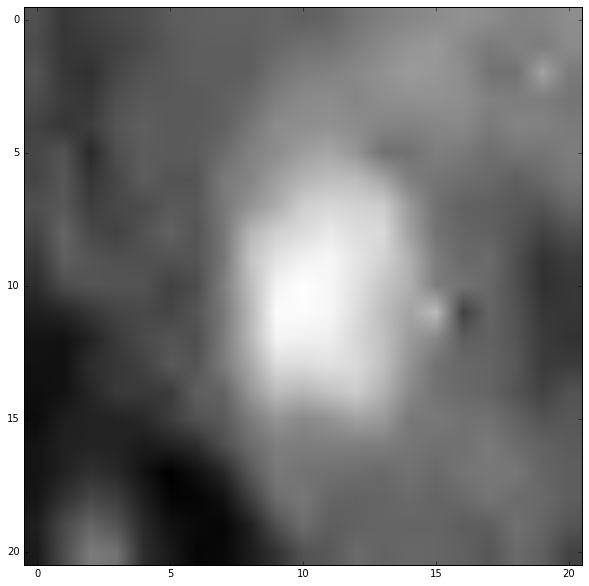

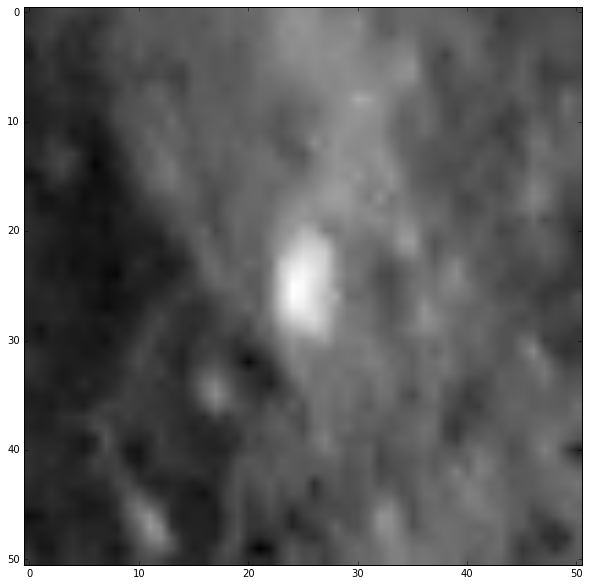

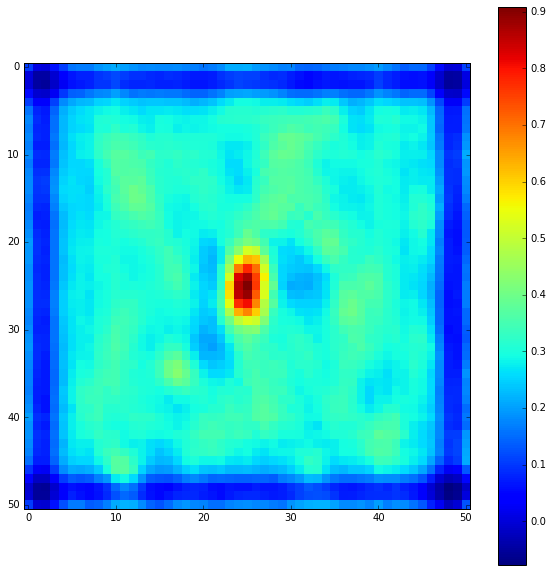

In [13]:
from scipy.ndimage.interpolation import zoom
from scipy.stats.stats import pearsonr 

figsize(10,10)
e = cg.edge[0][1]
matches = e.matches
clean_keys = ['subpixel']

full_offsets = np.zeros((len(matches), 3))

if clean_keys:
    matches, mask = e._clean(clean_keys)

# Preallocate the numpy array to avoid appending and type conversion
edge_offsets = np.empty((len(matches),3))

# for each edge, calculate this for each keypoint pair
for i, (idx, row) in enumerate(matches.iterrows()):
    s_idx = int(row['source_idx'])
    d_idx = int(row['destination_idx'])
    s_kps = e.source.get_keypoints().iloc[s_idx]
    d_kps = e.destination.get_keypoints().iloc[d_idx]

    s_keypoint = e.source.get_keypoints().iloc[s_idx][['x', 'y']].values
    d_keypoint = e.destination.get_keypoints().iloc[d_idx][['x', 'y']].values

    # Get the template and search windows
    s_template = sp.clip_roi(e.source.geodata, s_keypoint, 21)
    d_search = sp.clip_roi(e.destination.geodata, d_keypoint, 51)
    imshow(s_template, cmap='Greys')
    show()
    imshow(d_search, cmap='Greys')
    show()
    
    ciratefi(s_template, d_search, upsampling=1)
    break